In [124]:
import numpy as np
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from random import random, seed
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [125]:
sns.set_theme(style='whitegrid')

The Franke function:

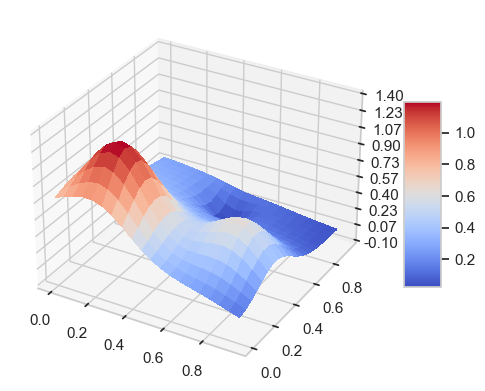

In [5]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Make data.
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x,y)


def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4


z = FrankeFunction(x, y)

# Plot the surface.
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

Implementing the design matrix:

In [128]:
def Vandermonde_design_matrix(x: np.ndarray, p: int) -> np.ndarray:
    """Sets up the design matrix given an input array x,
    and the degree of the polynomial fit
    without the intercept."""
    Vandermonde: np.ndarray = [x**i for i in range(1,p+1)]
    return np.hstack(Vandermonde)

### a)

First function for experimentation

In [7]:
np.random.seed(3)
n = 100
# Make data set.
x = np.linspace(-3, 3, n).reshape(-1, 1)
y = np.exp(-x**2) + 1.5 * np.exp(-(x-2)**2)+ np.random.normal(0, 0.1, x.shape)

In [38]:
MSE_OLS_train = np.zeros(6)
MSE_OLS_test = np.zeros(6)
R2_OLS_train = np.zeros(6)
R2_OLS_test = np.zeros(6)

beta_values = []

for i in range(6):
    # Constructing the design matrix
    X = Vandermonde_design_matrix(x, i)

    # Splitting the data into train and test and scaling the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

    ## scaling the data
    X_train_mean = np.mean(X_train, axis=0)

    x_train_scaled = X_train - X_train_mean
    x_test_scaled = X_test - X_train_mean

    y_mean = np.mean(y_train)
    y_train_scaled = y_train - y_mean


    # fitting the data with OLS
    OLS_beta = np.linalg.pinv(x_train_scaled.T @ x_train_scaled) @ x_train_scaled.T @ y_train_scaled

    intercept = np.mean(y_mean - X_train_mean @ OLS_beta)

    y_tilde_OLS = x_train_scaled @ OLS_beta + y_mean
    y_predict_OLS = x_test_scaled @ OLS_beta + y_mean

    MSE_OLS_train[i] = mean_squared_error(y_tilde_OLS, y_train)
    MSE_OLS_test[i] = mean_squared_error(y_predict_OLS, y_test)
    R2_OLS_train[i] = r2_score(y_tilde_OLS, y_train)
    R2_OLS_test[i] = r2_score(y_predict_OLS, y_test)

    beta_values.append(list(OLS_beta))

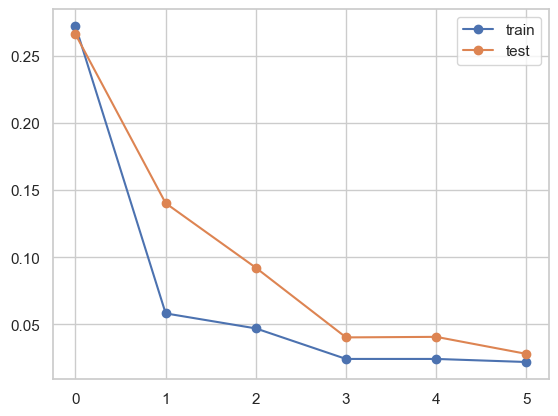

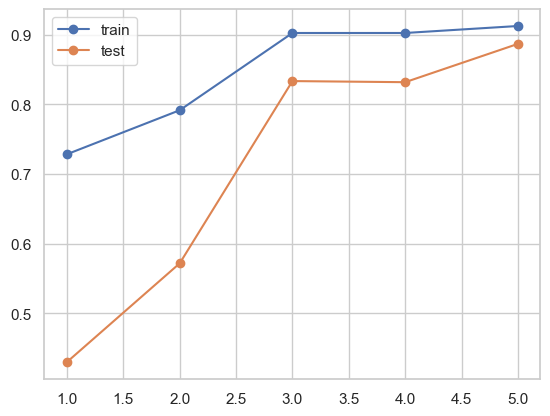

In [34]:
N = list(range(6))

plt.plot(N,MSE_OLS_train, 'o-', label='train')
plt.plot(N,MSE_OLS_test, 'o-', label='test')
plt.legend()
plt.show()

plt.plot(N[1:],R2_OLS_train[1:], 'o-', label='train')
plt.plot(N[1:],R2_OLS_test[1:], 'o-', label='test')
plt.legend()
plt.show()

In [42]:
beta = np.zeros((6,6))

for i in range(6):
    for j in range(len(beta_values[i])):
        beta[i,j] = beta_values[i][j]

C:\Users\maria\AppData\Local\Temp\ipykernel_26320\541528433.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  beta[i,j] = beta_values[i][j]


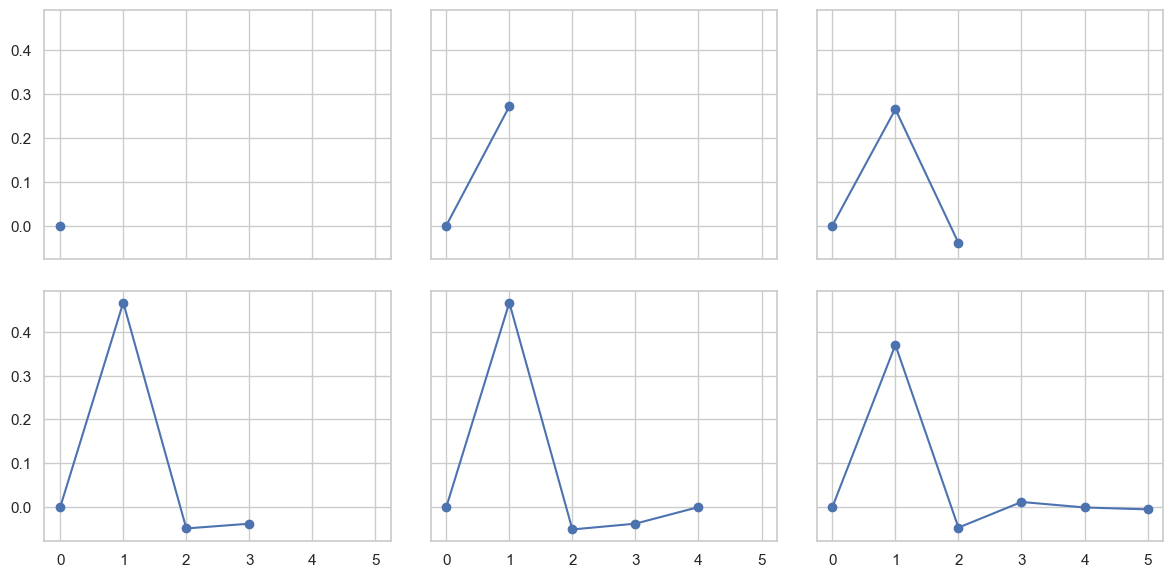

In [72]:
fig, axs = plt.subplots(2,3, figsize=(12, 6), sharex=True, sharey=True)
fig.tight_layout()

N = list(range(6))

for row in range(2):
    for col in range(3):
        axs[row, col].plot(N[:3*row + col + 1], beta[3*row + col][:3*row + col + 1], 'o-')
        
plt.show()

### b)

In [76]:
MSE_Ridge_train = np.zeros((3, 6))
MSE_Ridge_test = np.zeros((3, 6))
R2_Ridge_train = np.zeros((3, 6))
R2_Ridge_test = np.zeros((3, 6))

beta_values = []
llambda = np.logspace(-4, 2, 6)
for i in range(6):
    # Constructing the design matrix
    X = Vandermonde_design_matrix(x, i)

    # Splitting the data into train and test and scaling the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

    # scaling the data
    X_train_mean = np.mean(X_train, axis=0)

    x_train_scaled = X_train - X_train_mean
    x_test_scaled = X_test - X_train_mean

    y_mean = np.mean(y_train)
    y_train_scaled = y_train - y_mean


    # fitting the data with Ridge regression
    I = np.eye(i+1,i+1)
    MSEPredict = np.zeros(len(llambda))
    MSETrain = np.zeros(len(llambda))
    for j in range(len(llambda)): 
        Ridge_beta = np.linalg.pinv(x_train_scaled.T@x_train_scaled + llambda[j]*I) @ x_train_scaled.T @ y_train_scaled
        
        y_tilde_Ridge = x_train_scaled @ Ridge_beta + y_mean
        y_predict_Ridge = x_test_scaled @ Ridge_beta + y_mean

        # calculating the MSE for each lambda-value
        MSEPredict[j] = mean_squared_error(y_test,y_predict_Ridge)
        MSETrain[j] = mean_squared_error(y_train,y_tilde_Ridge)

    MSE_Ridge_train[i] = MSETrain
    MSE_Ridge_test[i] = MSEPredict

    beta_values.append(list(OLS_beta))

IndexError: index 3 is out of bounds for axis 0 with size 3

In [97]:
def design_matrix(x: np.ndarray, p: int) -> np.ndarray:
    """Sets up the design matrix given an input array x,
    and the degree of the polynomial fit"""
    X = np.zeros((n,p))
    for degree in range(1,p+1): #No intercept column
        X[:,degree-1] = x[:,0]**(degree)

    return X

In [99]:
MSE_OLS_train = np.zeros(6)
MSE_OLS_test = np.zeros(6)
R2_OLS_train = np.zeros(6)
R2_OLS_test = np.zeros(6)

beta_values = []
for i in range(1,6):
    # Constructing the design matrix
    X = design_matrix(x, i)

    # Splitting the data into train and test and scaling the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

    # scaling the data
    X_train_mean = np.mean(X_train, axis=0)

    X_train_scaled = X_train - X_train_mean
    X_test_scaled = X_test - X_train_mean

    y_mean = np.mean(y_train)
    y_train_scaled = y_train - y_mean


    # fitting the data with OLS
    OLS_beta = np.linalg.pinv(X_train_scaled.T @ X_train_scaled) @ X_train_scaled.T @ y_train_scaled
    intercept_OLS = y_mean - X_train_mean @ OLS_beta

    y_tilde_OLS = X_train_scaled @ OLS_beta + y_mean
    y_predict_OLS = X_test_scaled @ OLS_beta + y_mean

    MSE_OLS_train[i] = mean_squared_error(y_tilde_OLS, y_train)
    MSE_OLS_test[i] = mean_squared_error(y_predict_OLS, y_test)
    R2_OLS_train[i] = r2_score(y_tilde_OLS, y_train)
    R2_OLS_test[i] = r2_score(y_predict_OLS, y_test)

    beta_values.append(list(OLS_beta))

1 [[0.27148507]]
2 [[ 0.26509503]
 [-0.03945136]]
3 [[ 0.46648054]
 [-0.04837141]
 [-0.03754793]]
4 [[ 4.66129853e-01]
 [-5.06851398e-02]
 [-3.74614945e-02]
 [ 3.04539418e-04]]
5 [[ 0.36992141]
 [-0.04648093]
 [ 0.01195624]
 [-0.00052898]
 [-0.00492239]]


In [89]:
beta_values

[[],
 [array([0.27148507])],
 [array([0.26509503]), array([-0.03945136])],
 [array([0.46648054]), array([-0.04837141]), array([-0.03754793])],
 [array([0.46612985]),
  array([-0.05068514]),
  array([-0.03746149]),
  array([0.00030454])]]

### c)

In [111]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

Franke function

In [112]:
# Make data.
n = 100
x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
x, y = np.meshgrid(x,y)

# we unravel the values to change the shape from (100, 100) to (10000, )
x = x.ravel()
y = y.ravel()

def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4


z = FrankeFunction(x, y)

In [121]:
MSE = np.zeros(3)
for ex_p in [5, 10, 15]:
    # we stack the values of x and y beside each other
    X = np.column_stack((x,y))

    # we use pipeline to fit our model
    pipeline = make_pipeline(
        PolynomialFeatures(degree=ex_p),
        StandardScaler(),
        Lasso())

    pipeline.fit(X,z)
    z_predict = pipeline.predict(X)

    MSE[ex_p//5-1] = mean_squared_error(z_predict, z)

In [114]:
MSE

array([0.08235519, 0.08235519, 0.08235519])

In [122]:
x_plot = x.reshape((n, n))
y_plot = y.reshape((n, n))
z_plot = z.reshape((n, n))
z_pred_plot = z_predict.reshape((n, n))

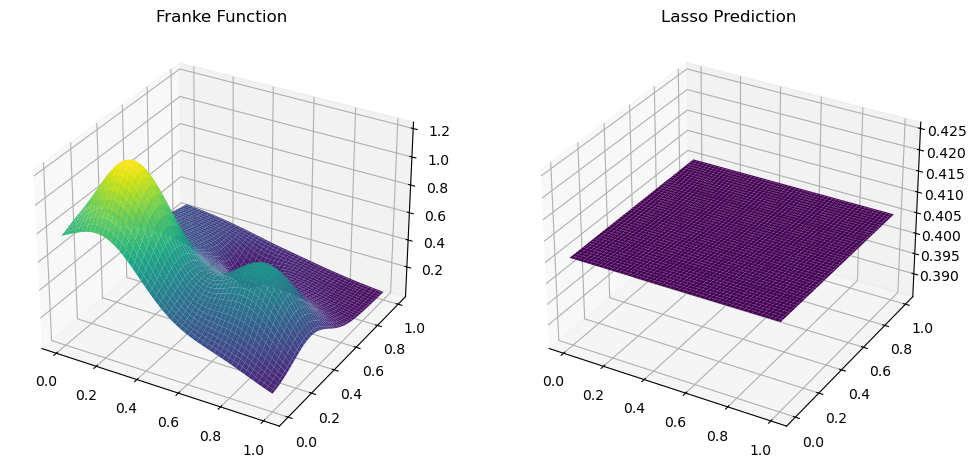

In [123]:
fig = plt.figure(figsize=(12, 6))

# Plotting the Franke function
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(x_plot, y_plot, z_plot, cmap='viridis', edgecolor='none')
ax.set_title('Franke Function')

# Plot the polynomial regression prediction
ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(x_plot, y_plot, z_pred_plot, cmap='viridis', edgecolor='none')
ax.set_title('Lasso Prediction')

plt.show()
